<a href="https://colab.research.google.com/github/LoPA607/IE643/blob/main/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q timm==0.9.2 torch torchvision pillow tqdm

In [2]:
import os
import random
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torchvision.utils import save_image
import math

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 224                 # ViT base patch16 standard size
VIT_NAME = 'vit_base_patch16_224'
EXTRACT_LAYERS = [2, 5, 8, 11] # layer indices to extract features from
NUM_STEPS = 50
LR = 0.002
STYLE_WEIGHT = 1e9
CONTENT_WEIGHT = 0.000001
TV_WEIGHT = 1
JITTER_MAX = 3              # max pixel jitter to apply each step (helps remove seams)
MULTI_SCALE = [1.0, 0.75, 0.5] # optimize at these image scales (coarse->fine)
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
def load_image(path, size=IMG_SIZE):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0).to(DEVICE)

def denorm_tensor(tensor):
    # input in [0,1], returns clamped [0,1]
    return tensor.clamp(0., 1.)

def save_out(tensor, path):
    t = denorm_tensor(t.detach().cpu())
    save_image(t, path)

In [5]:
class ViTTokenExtractor:
    def __init__(self, model, layers):
        """
        model: timm ViT model
        layers: list of transformer block indices to hook outputs from
        """
        self.model = model
        self.layers = layers
        self._hooks = []
        self.outputs = {}
        self._register_hooks()

    def _hook_fn(self, idx):
        def hook(module, input, output):
            # output shape (B, N+1, D) for timm ViT blocks; keep all tokens
            self.outputs[idx] = output
        return hook

    def _register_hooks(self):
        # timm ViT typically has model.blocks
        for idx in self.layers:
            block = self.model.blocks[idx]
            h = block.register_forward_hook(self._hook_fn(idx))
            self._hooks.append(h)

    def remove(self):
        for h in self._hooks:
            h.remove()

    @torch.no_grad()
    def features(self, x):
        """Run forward_features and return dict {layer_idx: tokens (B, N, D) excluding cls}"""
        self.outputs.clear()
        _ = self.model.forward_features(x)
        feats = {}
        for k, v in self.outputs.items():
            # drop cls token at index 0 -> get patch tokens: (B, N, D)
            tokens = v[:, 1:, :].detach()  # (B, N, D)
            feats[k] = tokens
        return feats

In [6]:
def gram_tokens(tokens):
    """
    tokens: (B, N, D)
    returns gram: (B, D, D)
    """
    B, N, D = tokens.shape
    t = tokens.transpose(1, 2)  # (B, D, N)
    g = torch.bmm(t, tokens) / (D * N)
    return g

In [7]:
def total_variation_loss(x):
    # x: (B, C, H, W), values in [0,1]
    diff_x = x[:, :, :, 1:] - x[:, :, :, :-1]
    diff_y = x[:, :, 1:, :] - x[:, :, :-1, :]
    return torch.mean(torch.abs(diff_x)) + torch.mean(torch.abs(diff_y))

In [8]:
def random_jitter(img, max_jitter):
    """Random circular shift (wrap-around) by up to +/- max_jitter pixels in x and y."""
    if max_jitter <= 0:
        return img, (0, 0)
    B, C, H, W = img.shape
    dx = random.randint(-max_jitter, max_jitter)
    dy = random.randint(-max_jitter, max_jitter)
    # roll performs wrap-around; helps avoid black borders
    img_j = torch.roll(img, shifts=(dy, dx), dims=(2, 3))
    return img_j, (dx, dy)

def undo_jitter(img, shift):
    dx, dy = shift
    return torch.roll(img, shifts=(-dy, -dx), dims=(2, 3))

In [9]:
def vit_style_transfer(content_path, style_path, out_prefix='vit_stylized',
                       steps=NUM_STEPS, lr=LR,
                       style_w=STYLE_WEIGHT, content_w=CONTENT_WEIGHT, tv_w=TV_WEIGHT):
    # Load ViT
    print("Loading ViT model:", VIT_NAME)
    vit = timm.create_model(VIT_NAME, pretrained=True).to(DEVICE).eval()
    extractor = ViTTokenExtractor(vit, EXTRACT_LAYERS)

    # Load images (we will rescale for multi-scale)
    content_full = Image.open(content_path).convert('RGB')
    style_full = Image.open(style_path).convert('RGB')

    # Precompute style features at base scale (ViT expects specific size)
    style_tensor_base = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])(style_full).unsqueeze(0).to(DEVICE)
    style_tensor_base = normalize_imagenet(style_tensor_base)
    style_feats_base = extractor.features(style_tensor_base)

    # define initial image: start from content (resized at base scale)
    base_size = IMG_SIZE
    content_tensor = transforms.Compose([transforms.Resize((base_size, base_size)), transforms.ToTensor()])(content_full).unsqueeze(0).to(DEVICE)
    content_tensor = normalize_imagenet(content_tensor)

    # target: optimize pixels starting from content
    target = content_tensor.clone().requires_grad_(True)

    optimizer = optim.Adam([target], lr=lr)

    # helper: feature extract for content at base scale
    content_feats_base = extractor.features(content_tensor)

    print("Starting optimization...")
    for step in tqdm(range(1, steps + 1)):
        optimizer.zero_grad()

        # Multi-scale losses: compute at each scale (coarse to fine)
        total_style_loss = 0.0
        total_content_loss = 0.0

        for scale in MULTI_SCALE:
            # resize target to current scale
            s = max(32, int(IMG_SIZE * scale))
            target_resized = nn.functional.interpolate(target, size=(s, s), mode='bilinear', align_corners=False)

            # apply random jitter to break patch alignment
            target_jittered, shift = random_jitter(target_resized, max_jitter=JITTER_MAX)

            # extract features (tokens) for target_jittered
            # NOTE: ViT feature extraction expects IMG_SIZE input, so resize here before extracting
            target_for_feats = nn.functional.interpolate(target_jittered, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
            feats_t = extractor.features(target_for_feats)  # dict layer->(B,N,D)


            # content loss only at base scale (or we can compute across scales)
            if math.isclose(scale, 1.0):
                for k in content_feats_base:
                    cf = content_feats_base[k]
                    tf = feats_t[k]
                    total_content_loss += nn.functional.mse_loss(tf, cf)

            # style loss: compare Gram matrices at this scale between target and precomputed style
            # NOTE: Style feats were precomputed at base scale, so use those
            style_feats = style_feats_base # Use base scale style features
            for k in style_feats:
                gram_t = gram_tokens(feats_t[k])
                gram_s = gram_tokens(style_feats[k])
                total_style_loss += nn.functional.mse_loss(gram_t, gram_s)

        # normalize by number of scales and layers to keep magnitudes stable
        n_scales = len(MULTI_SCALE)
        n_layers = len(EXTRACT_LAYERS)
        total_style_loss = total_style_loss / (n_scales * n_layers)
        total_content_loss = total_content_loss / max(1.0, n_layers)  # content computed only at base

        # total variation smoothing
        tv_loss = total_variation_loss(target)

        loss = content_w * total_content_loss + style_w * total_style_loss + tv_w * tv_loss
        loss.backward()
        optimizer.step()

        # ensure target remains in [0,1] before normalization
        with torch.no_grad():
            # undo normalization clamping: target is in normalized domain; map to 0..1 then renormalize
            t = denormalize_imagenet(target)
            t = t.clamp(0.0, 1.0)
            target.data.copy_(normalize_imagenet(t))

        if step % 50 == 0 or step == steps:
            # save intermediate result (denormalize)
            out_img = denormalize_imagenet(target).detach().cpu().squeeze(0)
            save_image(out_img.clamp(0,1), f"{out_prefix}_step{step}.png")
            print(f"Step {step}: loss={loss.item():.4f} (style={total_style_loss.item():.4f}, content={total_content_loss.item():.4f}, tv={tv_loss.item():.6f})")

    extractor.remove()
    final_img = denormalize_imagenet(target).detach().cpu().squeeze(0)
    save_image(final_img.clamp(0,1), f"{out_prefix}_final.png")
    print("Saved final:", f"{out_prefix}_final.png")
    return f"{out_prefix}_final.png"

Loading ViT model: vit_base_patch16_224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Starting optimization...


  6%|▋         | 52/800 [00:03<01:02, 11.94it/s]

Step 50: loss=8151.0566 (style=0.0000, content=0.3034, tv=0.507368)


 13%|█▎        | 101/800 [00:06<00:34, 20.52it/s]

Step 100: loss=9075.5469 (style=0.0000, content=0.5946, tv=0.425015)


 19%|█▉        | 153/800 [00:08<00:37, 17.47it/s]

Step 150: loss=7723.4849 (style=0.0000, content=0.5077, tv=0.362356)


 26%|██▌       | 206/800 [00:11<00:24, 24.12it/s]

Step 200: loss=9489.2686 (style=0.0000, content=0.3993, tv=0.312564)


 32%|███▏      | 255/800 [00:13<00:22, 23.97it/s]

Step 250: loss=8425.7773 (style=0.0000, content=0.6106, tv=0.272097)


 38%|███▊      | 304/800 [00:15<00:20, 23.98it/s]

Step 300: loss=8122.4019 (style=0.0000, content=0.6096, tv=0.238892)


 44%|████▍     | 355/800 [00:17<00:18, 23.62it/s]

Step 350: loss=8079.2617 (style=0.0000, content=0.5748, tv=0.211258)


 50%|█████     | 404/800 [00:19<00:16, 24.19it/s]

Step 400: loss=7069.9741 (style=0.0000, content=0.7309, tv=0.187856)


 57%|█████▋    | 455/800 [00:21<00:14, 23.40it/s]

Step 450: loss=7167.3335 (style=0.0000, content=0.6940, tv=0.168039)


 63%|██████▎   | 504/800 [00:23<00:12, 24.11it/s]

Step 500: loss=7862.6040 (style=0.0000, content=0.8049, tv=0.151267)


 69%|██████▉   | 555/800 [00:26<00:10, 23.50it/s]

Step 550: loss=6796.2832 (style=0.0000, content=0.8546, tv=0.136967)


 76%|███████▌  | 604/800 [00:28<00:08, 23.90it/s]

Step 600: loss=6691.9780 (style=0.0000, content=0.8440, tv=0.124729)


 82%|████████▏ | 655/800 [00:30<00:06, 23.51it/s]

Step 650: loss=6165.4619 (style=0.0000, content=0.8792, tv=0.114280)


 88%|████████▊ | 704/800 [00:32<00:03, 24.13it/s]

Step 700: loss=5512.6157 (style=0.0000, content=0.9268, tv=0.105327)


 94%|█████████▍| 755/800 [00:34<00:01, 23.39it/s]

Step 750: loss=4238.9224 (style=0.0000, content=1.0549, tv=0.097646)


100%|██████████| 800/800 [00:36<00:00, 21.87it/s]

Step 800: loss=4064.8721 (style=0.0000, content=1.1552, tv=0.091014)
Saved final: vit_hybrid_final.png
Output saved to: vit_hybrid_final.png


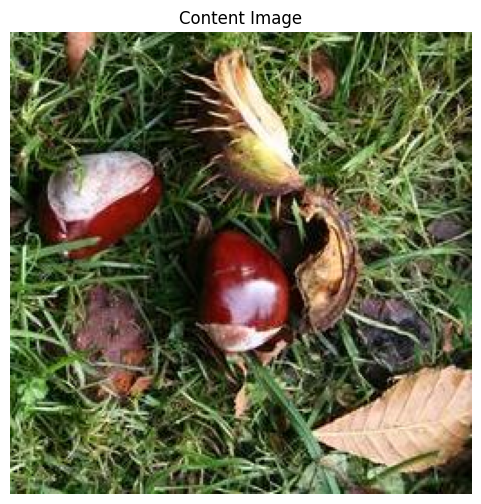

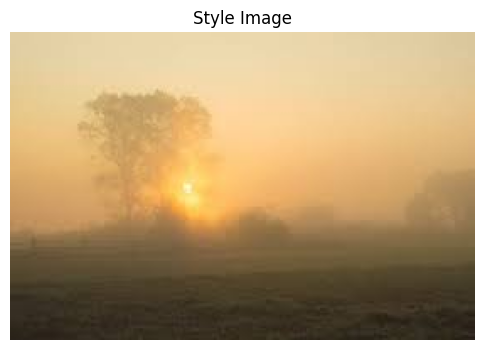

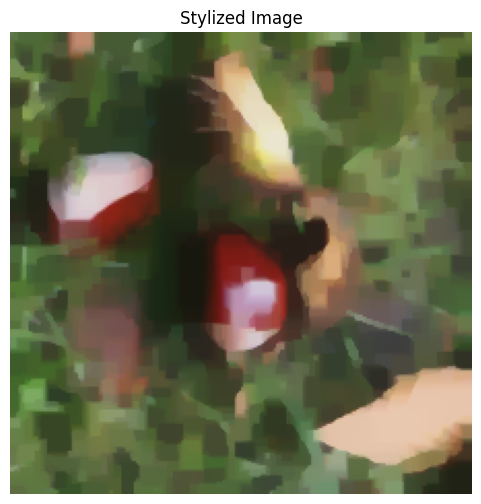

In [10]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1,3,1,1)

def normalize_imagenet(x):
    return (x - IMAGENET_MEAN) / IMAGENET_STD

def denormalize_imagenet(x):
    return x * IMAGENET_STD + IMAGENET_MEAN

# -----------------------
# Small helpers
# -----------------------
from torchvision.utils import save_image
from IPython.display import display
import matplotlib.pyplot as plt

def display_image(path, title):
    img = Image.open(path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


# -----------------------
# Run example (update paths)
# -----------------------
if __name__ == "__main__":
    content_path = "content2.jpg"   # change to your content path
    style_path = "style3.jpeg"      # change to your style path
    out = vit_style_transfer(content_path, style_path, out_prefix='vit_hybrid', steps=800)
    print("Output saved to:", out)

    # Display images
    display_image(content_path, "Content Image")
    display_image(style_path, "Style Image")
    display_image(out, "Stylized Image")